In [1]:
import tensorflow as tf
from glob import glob
from typing import List,Tuple
from data_loader import dataset_loader
from matplotlib import pyplot as plt
import numpy as np
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.3.0
Num GPUs Available:  8


In [2]:
dataset_dir='/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records'
ds_loader = dataset_loader(tfrec_dir=dataset_dir,batch_size=32)
ds_train,ds_valid,ds_test= ds_loader.build_dataset()

Number of records, Train files:408, validation files:88, Test Files:87
Building Dataset.......

((TensorSpec(shape=(None, 1536, 1536), dtype=tf.int8, name=None),
  TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.string, name=None)),
 TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None))


In [3]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras.backend as K


def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow tensor
    :param y_p red: TensorFlow tensor of the same shape as y_true
    :return: float
    """
    #original euclidean distance loss =  K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    #loss = K.mean(K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1)))
    loss =  K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    return loss


#(example["grid_map"],example["grid_org_res"],example["left_bnd"],example["right_bnd"],example#["car_odo"],example["init_path"])
def dense_net(mid_output):
    output = layers.Dense(128, activation='linear')(mid_output)
    output = layers.BatchNormalization()(output)
    #output = layers.ReLU()(output)
    output = layers.LeakyReLU()(output)
    #output = layers.BatchNormalization()(output)
    output = layers.Dropout(0.6)(output)
    
    
    output = layers.Dense(96, activation='linear')(output)
    output = layers.BatchNormalization()(output)
    #output = layers.ReLU()(output)
    output = layers.LeakyReLU()(output)
    #output = layers.BatchNormalization()(output)
    #output = layers.Dropout(0.2)(output)
    
    
    output = layers.Dense(64, activation='linear')(output)
    output = layers.BatchNormalization()(output)
    output = layers.LeakyReLU()(output)
    #output = layers.BatchNormalization()(output)
    #output = layers.ReLU()(output)
    #output = layers.Dropout(0.2)(output)
    return output

def LSTM_net(mid_output):
    output = layers.Lambda(lambda x: tf.expand_dims(x, -1))(mid_output)

    output = layers.LSTM(50,activation='tanh', return_sequences=True)(output)
    #output = layers.LSTM(50,activation='tanh', return_sequences=True,recurrent_dropout=0.2)(output)
    #output = layers.Dropout(0.25)(output)

    output = layers.LSTM(50,activation='tanh')(output)
    return output

def nn():

    # Grid Map input
    ip_gridmap = layers.Input(shape=(1536,1536,1))

    #CNN - branch1
    #1x1 conv 
    #x_A = layers.Conv2D(3,kernel_size=1,strides=1)(ip_gridmap)
    
    x_A = layers.Conv2D(16,kernel_size=7,strides=2)(ip_gridmap)
    x_A = layers.ReLU()(x_A)
    x_A = layers.BatchNormalization()(x_A)
    x_A = layers.AvgPool2D(pool_size=(4,4))(x_A)

    x_A = layers.Conv2D(32,kernel_size=5,strides=2)(x_A)
    x_A = layers.ReLU()(x_A)
    x_A = layers.BatchNormalization()(x_A)
    x_A = layers.AvgPool2D(pool_size=(4,4))(x_A)

    
    x_A = layers.Conv2D(64,kernel_size=3,strides=2)(x_A)
    x_A = layers.BatchNormalization()(x_A)
    x_A = layers.ReLU()(x_A)
    x_A = layers.AvgPool2D(pool_size=(2,2))(x_A)


    x_A = layers.Flatten()(x_A)


    # Other inputs
    ip_grid_org_res = layers.Input(shape=(3,))
    ip_left_bnd = layers.Input(shape=(25,2))
    ip_right_bnd = layers.Input(shape=(25,2))
    ip_car_odo = layers.Input(shape=(3,))
    ip_init_path = layers.Input(shape=(25,2))
    #ip_filedetais = layers.Input
    
    """
    #branch 2
    x_B = layers.Conv1D(2,kernel_size=3,padding='same')(ip_init_path)
    #branch 3
    x_C = layers.Conv1D(2,kernel_size=3,padding='same')(ip_left_bnd)
    #branch 4
    x_D = layers.Conv1D(2,kernel_size=3,padding='same')(ip_right_bnd)
    """
    
    # branch 5
    conc_grid_orgres_car_odo = layers.concatenate([ip_grid_org_res,ip_car_odo])

    reshape_init_path = layers.Reshape((50,))(ip_init_path)
    reshape_left_bnd = layers.Reshape((50,))(ip_left_bnd)
    reshape_right_bnd = layers.Reshape((50,))(ip_right_bnd)

    
    #concatenate feature
    concat_feat = layers.concatenate([x_A, reshape_init_path, reshape_left_bnd, reshape_right_bnd, conc_grid_orgres_car_odo])

    #output = layers.Lambda(lambda x: tf.expand_dims(x, -1))(concat_feat)

    #FC
    
    #output = layers.LSTM(50,activation='tanh', return_sequences=True,recurrent_dropout=0.2)(output)
    #output = layers.Dropout(0.25)(output)

    #output = layers.LSTM(50, activation='tanh')(output)

    output = dense_net(concat_feat)
    
    output = layers.Dense(50, activation='linear')(output)
    
    output = layers.Reshape((25,2))(output)
    
    nn_fun = keras.models.Model(inputs = [ip_gridmap,ip_grid_org_res,ip_left_bnd, ip_right_bnd, ip_car_odo, ip_init_path], outputs= output)
    
    return nn_fun

In [5]:
pp_model = nn()
opt = tf.keras.optimizers.Adam(learning_rate=0.02)
pp_model.compile(optimizer=opt,loss=euclidean_distance_loss, metrics='accuracy')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.0001)
pp_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1536, 1536,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 765, 765, 16) 800         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 765, 765, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 765, 765, 16) 64          re_lu[0][0]                      
_______________________________________________________________________________________

In [17]:
history = pp_model.fit(ds_train,epochs=50,validation_data=ds_valid, callbacks=[reduce_lr])

Epoch 1/50
194/194 [==============================] - 24s 121ms/step - loss: 99.7981 - accuracy: 0.9179 - val_loss: 184.3652 - val_accuracy: 0.9531
Epoch 2/50
194/194 [==============================] - 23s 120ms/step - loss: 51.2847 - accuracy: 0.8585 - val_loss: 31.9322 - val_accuracy: 0.9531
Epoch 3/50
194/194 [==============================] - 23s 120ms/step - loss: 44.8654 - accuracy: 0.8777 - val_loss: 32.3077 - val_accuracy: 0.9465
Epoch 4/50
194/194 [==============================] - 23s 121ms/step - loss: 42.5076 - accuracy: 0.8834 - val_loss: 21.5439 - val_accuracy: 0.6523
Epoch 5/50
194/194 [==============================] - 23s 120ms/step - loss: 40.4501 - accuracy: 0.8916 - val_loss: 37.1091 - val_accuracy: 0.3464
Epoch 6/50
194/194 [==============================] - 24s 124ms/step - loss: 37.7082 - accuracy: 0.9032 - val_loss: 28.9963 - val_accuracy: 0.3464
Epoch 7/50
194/194 [==============================] - 23s 121ms/step - loss: 34.5185 - accuracy: 0.9294 - val_loss: 2

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


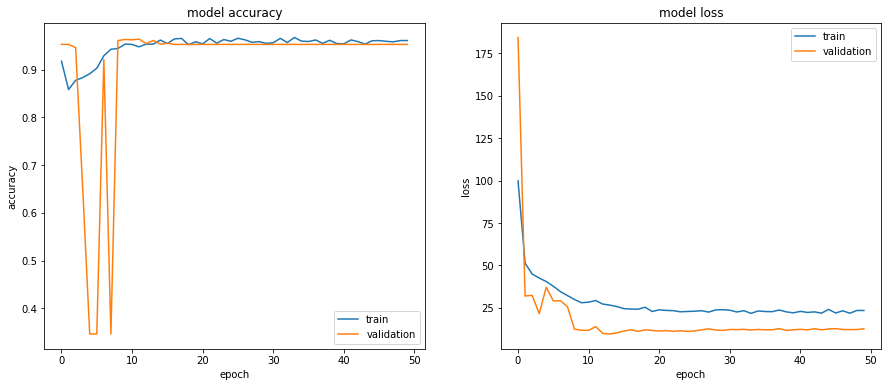

In [18]:

plt.figure(figsize=(15, 6))

print(history.history.keys())
# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
#plt.show()

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#plt.suptitle("Conv + LSTM + Dense Head")
plt.show()


In [12]:
test_loss,test_accuracy = pp_model.evaluate(ds_test)


42/42 [==============================] - 1s 33ms/step - loss: 18.3581 - accuracy: 0.9899


In [16]:
#pp_model.save("ppmodel_{}.h5".format(test_loss),save_format='h5')
pp_model=tf.keras.models.load_model('/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/iter_create_np_fromrbag/ppmodel_5.286526679992676.h5',compile=False)

pp_model.compile(optimizer=opt,loss=euclidean_distance_loss, metrics='accuracy')
#pp_model.summary()
test_loss,test_accuracy = pp_model.evaluate(ds_test)


42/42 [==============================] - 1s 31ms/step - loss: 4.8334 - accuracy: 0.9901


In [17]:
predictions = pp_model.predict(ds_test)
np.shape(predictions)

(1329, 25, 2)

In [18]:

def get_test_ds_size(ds_test):
    num_of_samples=0
    for input_batch, output_batch in ds_test:
        for i in range(0,len(input_batch[0].numpy())):
            num_of_samples+=1
    return num_of_samples

def get_np_test_ds(ds_test):

    samples = get_test_ds_size(ds_test)
    np_tst_gridmap = np.zeros(shape=(samples,1536,1536))
    np_tst_grid_org_res = np.zeros(shape=(samples,3))
    np_tst_left_bnd = np.zeros(shape=(samples,25,2))
    np_tst_right_bnd = np.zeros(shape=(samples,25,2))
    np_tst_car_odo = np.zeros(shape=(samples,3))
    np_tst_init_path = np.zeros(shape=(samples,25,2))
    np_tst_opt_path = np.zeros(shape=(samples,25,2))
    list_tst_file_details = []

    j=0
    for input_batch, output_batch in ds_test:
        
        for i in range(0,len(input_batch[0].numpy())):
            np_tst_gridmap[j]=input_batch[0][i].numpy()
            np_tst_grid_org_res[j] = input_batch[1][i].numpy()
            np_tst_left_bnd[j] = input_batch[2][i].numpy()
            np_tst_right_bnd[j] = input_batch[3][i].numpy()
            np_tst_car_odo[j] = input_batch[4][i].numpy()
            np_tst_init_path[j] = input_batch[5][i].numpy()
            list_tst_file_details.append(input_batch[6][i])

            np_tst_opt_path[j] = output_batch[i].numpy()
            j=j+1   
    return np_tst_gridmap,np_tst_grid_org_res,np_tst_left_bnd,np_tst_right_bnd,np_tst_car_odo,np_tst_init_path,list_tst_file_details,np_tst_opt_path
    

In [19]:
np_tst_gridmap,np_tst_grid_org_res,np_tst_left_bnd,np_tst_right_bnd,np_tst_car_odo,np_tst_init_path,list_tst_file_details,np_tst_opt_path =get_np_test_ds(ds_test)



In [26]:
def plot_scene(features):    
    grid_map = features["grid_map"]
    grid_org = features["grid_org_res"]
    left_bnd = features["left_bnd"]
    right_bnd = features["right_bnd"]
    init_path = features["init_path"]
    opt_path = features["opt_path"]
    car_odo = features["car_odo"]

    predict_path = features["predictions"]
    file_details=features["file_details"]

    #print(type(grid_map))
    fig=plt.figure(figsize=(7, 7))
    ax=fig.add_subplot(1,1,1)

    res = grid_org[2]
    ax.plot((left_bnd[:,0]-grid_org[0])/res,(left_bnd[:,1]-grid_org[1])/res,'-.', color='magenta',markersize=0.5, linewidth=0.5)

    ax.plot((init_path[:,0]-grid_org[0])/res,(init_path[:,1]-grid_org[1])/res,'o-', color='lawngreen',markersize=1, linewidth=1)
    ax.plot((opt_path[:,0]-grid_org[0])/res,(opt_path[:,1]-grid_org[1])/res,'--', color='yellow',markersize=1, linewidth=1)

    ax.plot((predict_path[:,0]-grid_org[0])/res,(predict_path[:,1]-grid_org[1])/res,'--', color='orange',markersize=1, linewidth=1)

    ax.plot((right_bnd[:,0]-grid_org[0])/res,(right_bnd[:,1]-grid_org[1])/res, '-.',color='magenta',markersize=0.5, linewidth=0.5)

    ax.plot((car_odo[0]-grid_org[0])/res,(car_odo[1]-grid_org[1])/res,'r*', color = 'red',markersize=8)


    ax.legend(['Left bound', 'gt_init_path', 'gt_opt_path','predicted_path','right bound', 'car_centre'], loc='lower left')

    ax.imshow(grid_map,origin="lower")

    ax.set_title(f"{file_details}\nTest Index: {features['testidx']}")
    save_fig_dir = '/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/test_results'
    fig.savefig(f"{save_fig_dir}/Test_index_{features['testidx']}.png",dpi=300)
    print(type(file_details))

    return ax,fig

<class 'tensorflow.python.framework.ops.EagerTensor'>


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa5d06b4370>,
 <Figure size 504x504 with 1 Axes>)

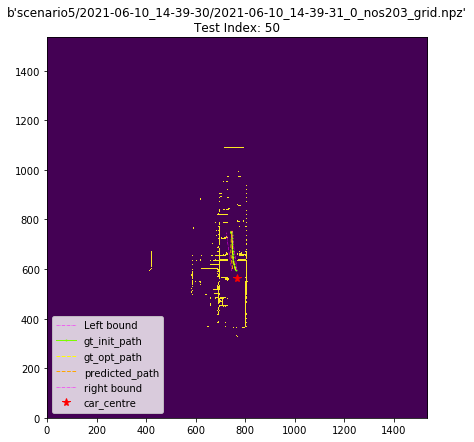

In [27]:
test_idx=50
test_data={}
test_data["grid_map"]= np_tst_gridmap[test_idx]
test_data["grid_org_res"]=np_tst_grid_org_res[test_idx]
test_data["left_bnd"]=np_tst_left_bnd[test_idx]
test_data["right_bnd"]=np_tst_right_bnd[test_idx]
test_data["car_odo"]=np_tst_car_odo[test_idx]
test_data["init_path"]=np_tst_init_path[test_idx]
test_data["opt_path"]=np_tst_opt_path[test_idx]
test_data["predictions"] = predictions[test_idx]
test_data["file_details"] = list_tst_file_details[test_idx]
test_data["testidx"] = test_idx
#print(test_data["left_bnd"])

plot_scene(test_data)

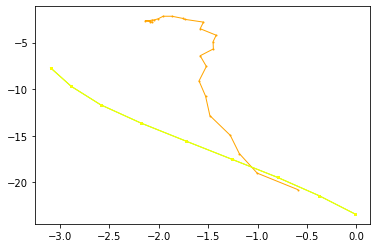

In [22]:
plt.plot(predictions[test_idx][:,0],predictions[test_idx][:,1],'-o', color = 'orange', markersize=1, linewidth=1)
plt.plot(np_tst_init_path[test_idx][:,0],np_tst_init_path[test_idx][:,1],'-o', color='lawngreen',markersize=2, linewidth=1)
plt.plot(np_tst_opt_path[test_idx][:,0],np_tst_opt_path[test_idx][:,1],'-o', color='yellow',markersize=2, linewidth=1)
plt.show()